# Problem: 
When we transform images with image points, they are just dropped, but we need to know *which* ones were dropped. 

## Solution:
We transform images once, and the image points twice. 

# Libraries

In [0]:
from fastai.vision import *

# Functions:

In [0]:
import zipfile

def get_coco(with_lbls:bool=True):
  !wget http://images.cocodataset.org/zips/val2017.zip
  zip_e = zipfile.ZipFile('val2017.zip', 'r')
  zip_e.extractall('')
  zip_e.close()
  if with_lbls:
    !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
    zip_f = zipfile.ZipFile('annotations_trainval2017.zip', 'r')
    zip_f.extractall('')
    zip_f.close

In [0]:
def get_keypoints(fname, max_persons=1, subset_divisor=None, prefix=None):
    "Open a COCO style json in `fname` and returns the lists of filenames (with maybe `prefix`) and keypoints without labels.  Currently a subset of the original data.  subset_divisor is the integer number to int_divide from the original set. 5=20%"
    annot_dict = json.load(open(fname))
    id2images, id2kpts, id2cats = {}, collections.defaultdict(list), collections.defaultdict(list)
   
    classes = {}
    for cat in annot_dict['categories']:
        classes[cat['id']] = cat['name']

    for o in annot_dict['annotations']:
        kpts = o['keypoints']
        list_of_kypts = [
            kpts[0],kpts[1],kpts[3],kpts[4],kpts[6],kpts[7],kpts[9],kpts[10],kpts[12],kpts[13],
            kpts[15],kpts[16],kpts[18],kpts[19],kpts[21],kpts[22],kpts[24],kpts[25],kpts[27],kpts[28],
            kpts[30],kpts[31],kpts[33],kpts[34],kpts[36],kpts[37],kpts[39],kpts[40],kpts[42],kpts[43],
            kpts[45],kpts[46],kpts[48],kpts[49]
        ]
        if len(set(list_of_kypts)) != 1:  # some data have all 0's
            id2kpts[o['image_id']].append(list_of_kypts)
    for o in annot_dict['images']:
        if o['id'] in id2kpts:
            id2images[o['id']] = ifnone(prefix, '') + o['file_name']

    all_ids = list(id2kpts.keys())
    subset_ids = [current_id for current_id in all_ids if len(id2cats[current_id]) <= max_persons]
    cats = ['fname']
    cats.extend(annot_dict['categories'][0]['keypoints'])
        
    return [id2images[k] for k in subset_ids], [[id2kpts[k], id2cats[k]] for k in subset_ids], cats

In [0]:
def make_df(fpath:Path, n_persons:int=1):
  fname = 'person_keypoints_val2017.json'
  fipath = Path(fpath/fname)
  impath = 'val2017/'
  imgs, kpts, cats = get_keypoints(fipath, n_persons)
  df = pd.DataFrame(columns=cats)
  al = []
  kp = kpts[0][0][0]
  for x in range(len(kpts)):
    kp = kpts[x][0][0]
    lis = []
    lis.append(impath+imgs[x])
    ad = []
    for y in range(0,34):
      ad.append(kp[y])
      if len(ad) == 2:
        ad[0], ad[1] = ad[1], ad[0]
        lis.append(ad)
        ad = []
    df.loc[x] = lis
  return df

In [0]:
class MakeLabels():
  def __init__(self, df:DataFrame, fname:str, path:PathOrStr):
    self.df = df
    self.fname = fname
    self.path = path
    self.vals = self.make_points(self.csv2kpts(self.fname))
    
  def flat_vals(self, vals):
    flat_list = []
    for sublist in vals:
      flat_tup = []
      for item in sublist:
        flat_tup.append(item)
      flat_list.append(flat_tup)
    return flat_list
    
  def img2kpts(self, name):
    return self.df.loc[self.df['fname'] == name].values[0][1:]
  
  def csv2kpts(self, fname):
    return self.flat_vals(self.img2kpts(fname))
  
  def make_points(self, pts):
    return tensor(pts).type(FloatTensor).cpu()

In [0]:
def get_ip(img, pts):
  return ImagePoints(FlowField(img.size, pts), scale=True, y_first=True)

# Get and Prep Data

In [0]:
get_coco()

In [0]:
img, kpts, cats = get_keypoints('annotations/person_keypoints_val2017.json', 1)

In [0]:
path = Path('annotations')

In [0]:
df = make_df(path)

In [12]:
df.head()

,fname,nose,left_eye,right_eye,left_ear,right_ear,left_shoulder,right_shoulder,left_elbow,right_elbow,left_wrist,right_wrist,left_hip,right_hip,left_knee,right_knee,left_ankle,right_ankle
0,val2017/000000425226.jpg,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[309, 142]","[320, 177]","[398, 191]","[317, 237]","[426, 233]","[233, 306]","[452, 92]","[468, 123]","[0, 0]","[469, 251]","[0, 0]","[551, 162]"
1,val2017/000000440475.jpg,"[192, 508]","[191, 510]","[191, 506]","[192, 512]","[192, 503]","[202, 515]","[202, 499]","[214, 524]","[215, 497]","[226, 516]","[224, 496]","[232, 511]","[230, 497]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
2,val2017/000000069213.jpg,"[97, 389]","[82, 405]","[80, 376]","[85, 434]","[86, 359]","[168, 473]","[156, 322]","[324, 474]","[290, 298]","[413, 444]","[358, 314]","[408, 413]","[399, 316]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
3,val2017/000000292456.jpg,"[76, 256]","[70, 260]","[0, 0]","[72, 269]","[0, 0]","[112, 254]","[99, 307]","[145, 236]","[150, 338]","[160, 200]","[0, 0]","[189, 270]","[188, 308]","[227, 257]","[246, 359]","[287, 251]","[0, 0]"
4,val2017/000000309391.jpg,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[267, 97]","[267, 87]","[279, 101]","[277, 83]","[289, 96]","[285, 83]","[288, 96]","[288, 90]","[303, 98]","[303, 89]","[318, 99]","[319, 88]"


In [0]:
path_im = Path('')

In [0]:
fname = df['fname'].iloc[0]

In [0]:
img = open_image(path_im/fname)

In [0]:
ip = get_ip(img, MakeLabels(df, fname, path_im).vals)

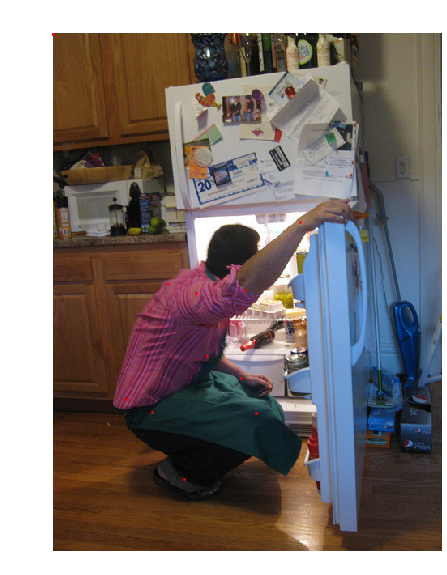

In [23]:
img.show(y=ip, figsize=(10,10))

## Applying Transformations

Here I will use random cropping until we get an image where the points are cut off

In [0]:
trans = zoom_crop(scale=(1, 2), do_rand=True)

One of the key things to do to link them is to make `do_resolve` False. Also we will make use of the `remove_out`. This will remove any points that are out of the image.

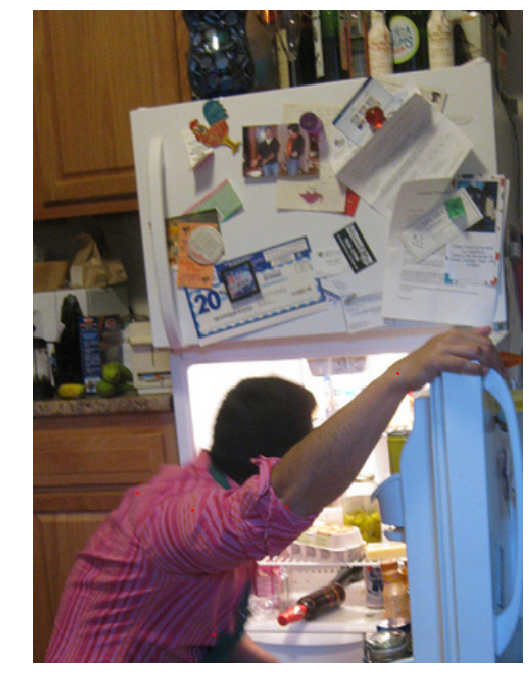

In [37]:
img2 = img.apply_tfms(trans)
pts2 = ip.apply_tfms(trans, do_resolve=False, remove_out=True)
img2.show(y=pts2, figsize=(12,12))

Here we have an example of where only 5 points are here. Which classes do they belong to? How do we find that out? Let's look at the `.data`

In [32]:
pts2.data

tensor([[ 0.4780, -0.5782],
        [ 0.5314, -0.3515],
        [ 0.9103, -0.2609],
        [ 0.5168,  0.0371],
        [ 0.1088,  0.4839]])

That tells us nothing.... But what if we run the same transformation *without* the drop? We only apply this to the points, not the image.

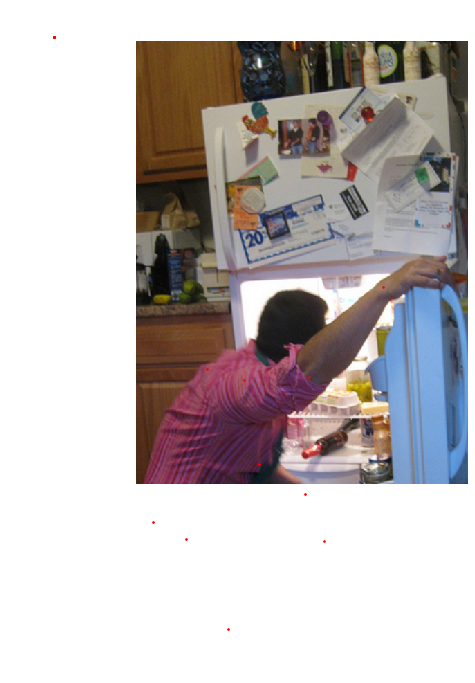

In [36]:
pts3 = ip.apply_tfms(trans, do_resolve=False, remove_out=False)
img2.show(y=pts3, figsize=(12,12))

Now we can see what the full transformation looks like. What about the data?

In [38]:
pts3.data

tensor([[-1.0230, -1.4979],
        [-1.0230, -1.4979],
        [-1.0230, -1.4979],
        [-1.0230, -1.4979],
        [-1.0230, -1.4979],
        [ 0.4780, -0.5782],
        [ 0.5314, -0.3515],
        [ 0.9103, -0.2609],
        [ 0.5168,  0.0371],
        [ 1.0463,  0.0111],
        [ 0.1088,  0.4839],
        [ 1.1726, -0.9021],
        [ 1.2503, -0.7013],
        [-1.0230, -1.4979],
        [ 1.2551,  0.1277],
        [-1.0230, -1.4979],
        [ 1.6534, -0.4487]])

Now we have the full list!

In [39]:
pts2.data

tensor([[ 0.4780, -0.5782],
        [ 0.5314, -0.3515],
        [ 0.9103, -0.2609],
        [ 0.5168,  0.0371],
        [ 0.1088,  0.4839]])

We can see that numbers 6,7,8,9, and 11 are on here (starting at 1). Let's look back at the dataframe we had

In [42]:
df.iloc[0]

fname             val2017/000000425226.jpg
nose                                [0, 0]
left_eye                            [0, 0]
right_eye                           [0, 0]
left_ear                            [0, 0]
right_ear                           [0, 0]
left_shoulder                   [309, 142]
right_shoulder                  [320, 177]
left_elbow                      [398, 191]
right_elbow                     [317, 237]
left_wrist                      [426, 233]
right_wrist                     [233, 306]
left_hip                         [452, 92]
right_hip                       [468, 123]
left_knee                           [0, 0]
right_knee                      [469, 251]
left_ankle                          [0, 0]
right_ankle                     [551, 162]
Name: 0, dtype: object

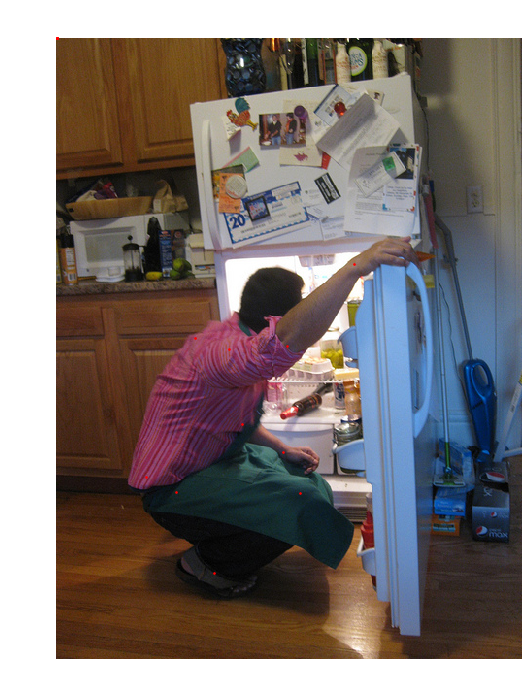

In [45]:
img.show(y=ip, figsize=(12,12))

The labels we have in the image are in the same order as they were originally.